In [1]:
import torch
import torch.nn as nn

# My code starts here

In [65]:
class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, batch_size = 4):
        super(ResNet,self).__init__()
        #number of Blocks
        self.numBlocks = [2,2,2,2]
        #convolution layer
        self.conv = [nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3, stride=2),
                    nn.Conv2d(out_channels, out_channels, kernel_size, padding=1),
                    nn.Conv2d(out_channels, out_channels*2, kernel_size, padding=1, stride=2),
                    nn.Conv2d(out_channels*2, out_channels*2, kernel_size, padding=1),
                    nn.Conv2d(out_channels*2, out_channels*4, kernel_size, padding=1, stride=2),
                    nn.Conv2d(out_channels*4, out_channels*4, kernel_size, padding=1),
                    nn.Conv2d(out_channels*4, out_channels*8, kernel_size, padding=1, stride=2),
                    nn.Conv2d(out_channels*8, out_channels*8, kernel_size, padding=1)]
        #batch norm layer
        self.bn = [nn.BatchNorm2d(num_features=out_channels),
                    nn.BatchNorm2d(num_features=out_channels*2),
                    nn.BatchNorm2d(num_features=out_channels*4),
                    nn.BatchNorm2d(num_features=out_channels*8)]
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(out_channels*8, 1000)
        self.softmax = nn.Softmax(dim=1)
        
        #transition the input channel for the residual path to add
        self.trans = [nn.Conv2d(out_channels, out_channels*2, kernel_size=1, stride=2),
                    nn.Conv2d(out_channels*2, out_channels*4, kernel_size=1, stride=2),
                    nn.Conv2d(out_channels*4, out_channels*8, kernel_size=1, stride=2)]
        #if in_channels == out_channels: no need to do transition
        self.isChanged = False
        self.out_channels = out_channels
        self.batch_size = batch_size
        
    def forward(self, x):
        #print(x.shape)
        x = self.conv[0](x)
        
        #print(x.shape)
        #max pooling layer
        x = self.maxpool(x)
        
        #print(x.shape)
        
        #block 1
        for i in range(self.numBlocks[0]):
            f_x = self.conv[1](x)
            f_x = self.bn[0](f_x)
            f_x = self.relu(f_x)
            f_x = self.conv[1](f_x)
            f_x = self.bn[0](f_x)
            #residual path
            x = f_x + x
            x = self.relu(x)
        
        self.isChanged = True
        
        #block 2
        for i in range(self.numBlocks[1]):
            if(self.isChanged):
                f_x = self.conv[2](x)
            else:
                f_x = self.conv[3](x)
            f_x = self.bn[1](f_x)
            f_x = self.relu(f_x)
            f_x = self.conv[3](f_x)
            f_x = self.bn[1](f_x)
            #residual path
            #in order for the residual path to work, we need to match the channels
            if(self.isChanged):
                x = self.trans[0](x)
                self.isChanged = False
            #print(f_x.shape, x.shape)
            x = f_x + x
            x = self.relu(x)
        
        self.isChanged = True
        
        #block 3
        for i in range(self.numBlocks[2]):
            if(self.isChanged):
                f_x = self.conv[4](x)
            else:
                f_x = self.conv[5](x)
            f_x = self.bn[2](f_x)
            f_x = self.relu(f_x)
            f_x = self.conv[5](f_x)
            f_x = self.bn[2](f_x)
            #residual path
            #in order for the residual path to work, we need to match the channels
            if(self.isChanged):
                x = self.trans[1](x)
                self.isChanged = False
            x = f_x + x
            x = self.relu(x)
        
        self.isChanged = True
        
        #block 4
        for i in range(self.numBlocks[3]):
            if(self.isChanged):
                f_x = self.conv[6](x)
            else:
                f_x = self.conv[7](x)
            f_x = self.bn[3](f_x)
            f_x = self.relu(f_x)
            f_x = self.conv[7](f_x)
            f_x = self.bn[3](f_x)
            #residual path
            #in order for the residual path to work, we need to match the channels
            if(self.isChanged):
                x = self.trans[2](x)
                self.isChanged = False
            x = f_x + x
            x = self.relu(x)
        #print(x.shape)
        #average pooling layer
        x = self.avgpool(x)
        #print(x.shape)
        #full connected layer
        #print(x.shape)
        #reshape
        x = x.view(-1,self.out_channels*8)
        x = self.linear(x)
        #softmax
        x = self.softmax(x)
        
        return x

In [60]:
from torchsummary import summary

In [61]:
resnet = ResNet(3,64,batch_size=2)

In [62]:
summary(resnet, (3, 224, 224))

torch.Size([2, 3, 224, 224])
torch.Size([2, 64, 112, 112])
torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28]) torch.Size([2, 128, 28, 28])
torch.Size([2, 128, 28, 28]) torch.Size([2, 128, 28, 28])
torch.Size([2, 512, 7, 7])
torch.Size([2, 512, 1, 1])
torch.Size([2, 512, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1           [-1, 64, 56, 56]               0
              ReLU-2           [-1, 64, 56, 56]               0
              ReLU-3           [-1, 64, 56, 56]               0
              ReLU-4           [-1, 64, 56, 56]               0
              ReLU-5           [-1, 64, 56, 56]               0
              ReLU-6          [-1, 128, 28, 28]               0
              ReLU-7          [-1, 128, 28, 28]               0
              ReLU-8          [-1, 128, 28, 28]               0
              ReLU-9          [-1, 128, 28, 28]               0
           

In [27]:
import torchvision
import torchvision.transforms as transforms

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


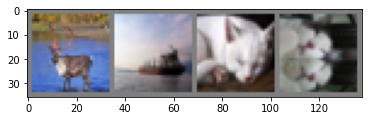

 deer  ship   cat   cat


In [29]:
 import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [68]:
import torch.optim as optim

resnet = ResNet(3,64, batch_size=4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [71]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(i, end = " ")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 6.808
[1,  4000] loss: 6.808
[1,  6000] loss: 6.807
[1,  8000] loss: 6.812
[1, 10000] loss: 6.815
[1, 12000] loss: 6.809
[2,  2000] loss: 6.811
[2,  4000] loss: 6.811
[2,  6000] loss: 6.812
[2,  8000] loss: 6.807
[2, 10000] loss: 6.807
[2, 12000] loss: 6.808
Finished Training


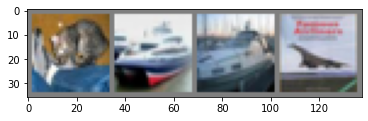

In [77]:
it = iter(testloader)
img, label = it.next()
imshow(torchvision.utils.make_grid(img))

In [78]:
out = resnet(img)

In [82]:
out[0]

tensor([3.2031e-07, 7.5627e-07, 8.4215e-07, 4.3654e-07, 5.8675e-07, 3.6873e-07,
        2.0524e-07, 9.9968e-01, 6.9827e-07, 1.1968e-07, 3.6097e-07, 4.1660e-07,
        3.2697e-07, 9.0537e-08, 2.4735e-07, 5.0585e-07, 3.2466e-07, 1.7953e-07,
        2.0012e-07, 1.4124e-07, 8.5426e-08, 7.4801e-08, 1.8216e-07, 2.9220e-07,
        3.2922e-07, 1.6054e-07, 7.7219e-08, 2.8718e-07, 3.8122e-07, 1.0064e-07,
        4.7205e-07, 8.0160e-08, 1.0664e-07, 2.9216e-07, 2.0509e-07, 5.6391e-07,
        8.6512e-07, 1.5043e-07, 4.0226e-07, 1.5616e-07, 1.5408e-07, 2.6542e-07,
        2.7489e-07, 2.1450e-07, 4.7230e-07, 2.5085e-07, 2.7275e-07, 2.0974e-07,
        1.7787e-07, 5.3165e-08, 3.5886e-07, 4.3486e-07, 8.0026e-07, 4.9148e-07,
        3.5166e-07, 1.5668e-07, 1.3722e-07, 7.3122e-07, 2.5870e-07, 4.0907e-07,
        2.6457e-07, 2.6575e-07, 1.7109e-07, 1.4859e-07, 7.0652e-07, 5.8132e-07,
        1.1584e-07, 7.2218e-07, 2.9941e-07, 2.6639e-07, 2.9336e-07, 3.4694e-07,
        5.2954e-07, 1.6614e-07, 2.6189e-